# Simple 2D Air Traffic Control - RL Demo

**Train an AI agent to control air traffic in 2-3 minutes!**

This notebook is completely self-contained - no external game server or browser required.

1. **Section 1**: Build a 2D ATC environment (aircraft moving in a square airspace)
2. **Section 2**: Test the environment with random actions
3. **Section 3**: Train an RL agent with PPO (Stable-Baselines3) using parallel environments
4. **Section 4**: Watch the trained agent perform

Aircraft enter from the edges of a 20nm x 20nm airspace. Your job:
- **Guide them** to exit points on opposite edges
- **Avoid conflicts** (aircraft must stay 3nm apart)
- **Be efficient** (minimize time to exit)

---
# Section 1: Build the Environment

All code is self-contained in this notebook!

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from IPython.display import clear_output
import time
import multiprocessing as mp
from wandb_utils import save_model_with_wandb

# Import the optimized environment from atc_rl module
from atc_rl.environment import Simple2DATCEnv, AIRSPACE_SIZE, SEPARATION_MIN, AIRCRAFT_SPEED

print(f'   Airspace: {AIRSPACE_SIZE}nm x {AIRSPACE_SIZE}nm')
print(f'   Minimum separation: {SEPARATION_MIN}nm')
print(f'   Aircraft speed: {AIRCRAFT_SPEED}nm/step')

   Airspace: 20.0nm x 20.0nm
   Minimum separation: 3.0nm
   Aircraft speed: 4.0nm/step


/home/jmzlx/Projects/atc/atc_rl_poc/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/jmzlx/Projects/atc/atc_rl_poc/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may hav

---
# Section 2: Test the Environment

Let's see how the environment works with random actions.

In [2]:
# Create environment
env = Simple2DATCEnv(max_aircraft=5, max_steps=50, render_mode='human')

print('✅ Environment created')
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

✅ Environment created
Observation space: Dict('aircraft': Box(-1.0, 1.0, (5, 6), float32), 'mask': Box(0, 1, (5,), uint8))
Action space: MultiDiscrete([ 6 25])


In [3]:
# Run random policy
print('Running random policy for 30 steps...')

obs, info = env.reset()
env.render()

for step in range(30):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    
    if step % 5 == 0:
        clear_output(wait=True)
        env.render()
        print(f"Step {step}: Aircraft={info['num_aircraft']}, "
              f"Exits={info['successful_exits']}, "
              f"Violations={info['separations_lost']}, "
              f"Reward={reward:.1f}")
        time.sleep(0.3)
    
    if terminated or truncated:
        break

print(f"\nFinal Results:")
print(f"  Steps: {info['step']}")
print(f"  Successful Exits: {info['successful_exits']}")
print(f"  Separation Violations: {info['separations_lost']}")
print(f"  Total Reward: {info['total_reward']:.1f}")

Step 5: Aircraft=0, Exits=2, Violations=0, Reward=400.0

Final Results:
  Steps: 6
  Successful Exits: 2
  Separation Violations: 0
  Total Reward: 200.1


---
# Section 3: Train with PPO

Now let's train an RL agent using Proximal Policy Optimization (PPO)!

## How PPO Works

PPO is a policy gradient method that:
- **Collects experience** from multiple parallel environments
- **Updates the policy** using clipped objective to prevent large changes
- **Balances exploration** (entropy) with exploitation (policy improvement)

## Hyperparameter Choices

- **Learning rate (5e-5)**: Conservative rate for stable learning
- **Batch size (256)**: Larger batches provide more stable gradients
- **GAE lambda (0.85)**: Controls bias-variance tradeoff in advantage estimation
- **Entropy coefficient (0.1)**: Encourages exploration to avoid local optima
- **N-steps (4096)**: More experience per update for better learning
- **Clip range (0.15)**: Prevents policy updates that are too large


In [4]:
# Enhanced Optimization: More Parallel Environments + Improved Episode System
print("Setting up enhanced ATC environments with improved episode system...")

def make_env(render_mode=None, max_aircraft=5, max_steps=1000):
    """Factory function for creating the vectorized ATC environment with improved episodes."""
    def _init():
        env = Simple2DATCEnv(
            max_aircraft=max_aircraft,
            max_steps=max_steps,  # Fallback only - episodes end when all aircraft resolved
            render_mode=render_mode,
            progressive_difficulty=True,  # Enable progressive difficulty
            initial_aircraft=2  # Start with 2 aircraft
        )
        return env
    return _init

# Determine number of parallel environments (use more cores)
num_envs = min(8, mp.cpu_count())  # Increased from 4 to 8
print(f"Creating {num_envs} parallel environments...")

# Create vectorized environment for training (no rendering in workers)
vec_env = SubprocVecEnv([make_env(render_mode=None) for _ in range(num_envs)])

# CRITICAL FIX: Wrap environment with normalization BEFORE creating PPO model
from stable_baselines3.common.vec_env import VecNormalize

print("🔧 Adding reward normalization for stable learning...")

# Wrap the environment with reward normalization
vec_env = VecNormalize(
    vec_env,
    norm_obs=True,      # Normalize observations
    norm_reward=True,   # Normalize rewards (crucial for learning!)
    clip_obs=10.0,     # Clip observations
    clip_reward=10.0,   # Clip rewards
    gamma=0.99,         # Discount factor for reward normalization
    epsilon=1e-8,       # Small value to avoid division by zero
)

print('✅ Reward normalization enabled!')
print('   - Observations normalized to mean=0, std=1')
print('   - Rewards normalized to mean=0, std=1')
print('   - This should fix the learning issues!')
print('')

print(f"✅ Enhanced parallel training environment created with {num_envs} environments")
print(f"   Expected speedup: {num_envs}x from parallelization (was 4x)")
print(f"   Additional benefit: More diverse experience per update")
print(f"   Improved episodes: Run until all aircraft resolved")
print(f"   Progressive difficulty: Starts with 2 aircraft, scales up")
print(f"   CRITICAL: Environment wrapped with normalization BEFORE PPO model creation")


Setting up enhanced ATC environments with improved episode system...
Creating 8 parallel environments...
🔧 Adding reward normalization for stable learning...
✅ Reward normalization enabled!
   - Observations normalized to mean=0, std=1
   - Rewards normalized to mean=0, std=1
   - This should fix the learning issues!

✅ Enhanced parallel training environment created with 8 environments
   Expected speedup: 8x from parallelization (was 4x)
   Additional benefit: More diverse experience per update
   Improved episodes: Run until all aircraft resolved
   Progressive difficulty: Starts with 2 aircraft, scales up
   CRITICAL: Environment wrapped with normalization BEFORE PPO model creation


In [5]:
# Import required modules
from stable_baselines3.common.callbacks import BaseCallback
from wandb.integration.sb3 import WandbCallback
import numpy as np
import wandb

# Initialize wandb first (required for WandbCallback)
wandb.init(
    entity="jmzlx.ai",
    project="atc-rl-poc",
    name="ppo-training-optimized",
    config={
        "environment": "Simple2DATC-Optimized",
        "algorithm": "PPO",
        "max_aircraft": 5,
        "max_steps": 1000,
        "learning_rate": 1.5e-4,  # OPTIMIZED: Slightly lower
        "batch_size": 256,
        "n_epochs": 8,  # OPTIMIZED: Fewer epochs
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_range": 0.2,
        "ent_coef": 0.2,  # Will be scheduled via callback
        "normalize_advantage": True,
        "progressive_difficulty": True,
        "initial_aircraft": 2,
    },
    sync_tensorboard=True,
    monitor_gym=True,
    save_code=True,
)

# Enhanced entropy scheduling callback with lower floor
class EntropyScheduleCallback(BaseCallback):
    def __init__(self, initial_ent_coef=0.2, final_ent_coef=0.01, verbose=0):  # LOWERED: 0.02 → 0.01
        super().__init__(verbose)
        self.initial_ent_coef = initial_ent_coef
        self.final_ent_coef = final_ent_coef
        self.total_training_steps = 200_000  # Set manually
        self.ev_threshold = 0.6  # Floor entropy when EV >= 0.6
        self.ev_high_count = 0  # Count consecutive high EV iterations
        
    def _on_step(self) -> bool:
        # Check if explained variance is high enough to floor entropy
        if hasattr(self.model, 'logger') and hasattr(self.model.logger, 'name_to_value'):
            ev = self.model.logger.name_to_value.get('train/explained_variance', 0)
            if ev >= self.ev_threshold:
                self.ev_high_count += 1
                if self.ev_high_count >= 2:  # Floor after 2+ consecutive high EV iterations
                    self.model.ent_coef = self.final_ent_coef
                    return True
            else:
                self.ev_high_count = 0
        
        # Normal linear decay from initial to final entropy coefficient
        progress = self.num_timesteps / self.total_training_steps
        if progress <= 1.0:
            current_ent_coef = self.initial_ent_coef - (self.initial_ent_coef - self.final_ent_coef) * progress
            self.model.ent_coef = current_ent_coef
        return True

# Correlation callback with COMPREHENSIVE diagnostics
class CorrCallback(BaseCallback):
    """Calculate correlation on training rollouts with comprehensive critic diagnostics."""
    def _on_step(self) -> bool:
        return True  # Required by BaseCallback
    
    def _on_rollout_end(self) -> None:
        buf = self.model.rollout_buffer
        r = buf.returns.flatten().copy()
        v = buf.values.flatten().copy()
        finite = np.isfinite(r) & np.isfinite(v)
        r, v = r[finite], v[finite]
        
        # Log comprehensive statistics
        self.logger.record("corr/#pairs", len(r))
        self.logger.record("corr/ret_std", float(r.std()))
        self.logger.record("corr/val_std", float(v.std()))
        self.logger.record("corr/value_pred_mean", float(v.mean()))
        self.logger.record("corr/value_pred_std", float(v.std()))
        self.logger.record("corr/return_mean", float(r.mean()))
        self.logger.record("corr/return_std", float(r.std()))
        
        # CRITIC DIAGNOSTICS
        # 1. Value bias (mean prediction error)
        value_bias = float((v - r).mean())
        self.logger.record("critic/value_bias", value_bias)
        
        # 2. Calibration slope (OLS of R on V)
        if len(r) > 10 and v.std() > 1e-6:
            # Simple OLS: slope = cov(R,V) / var(V)
            cov_rv = np.mean((r - r.mean()) * (v - v.mean()))
            var_v = v.std() ** 2
            calib_slope = cov_rv / (var_v + 1e-8)
            self.logger.record("critic/calib_slope", float(calib_slope))
        else:
            self.logger.record("critic/calib_slope", np.nan)
        
        # 3. Advantage statistics
        if hasattr(buf, 'advantages'):
            adv = buf.advantages.flatten().copy()
            adv_finite = adv[np.isfinite(adv)]
            if len(adv_finite) > 0:
                self.logger.record("critic/adv_mean", float(adv_finite.mean()))
                self.logger.record("critic/adv_std", float(adv_finite.std()))
        
        # Calculate correlation
        if len(r) >= 10000 and r.std() > 1e-6 and v.std() > 1e-6:
            r_norm = (r - r.mean())/(r.std()+1e-8)
            v_norm = (v - v.mean())/(v.std()+1e-8)
            corr = float((r_norm*v_norm).mean())
            self.logger.record("corr/v_return", corr)
            print(f"📈 Rollout: Corr={corr:.3f}, #pairs={len(r)}, "
                  f"val_std={v.std():.3f}, ret_std={r.std():.3f}, "
                  f"bias={value_bias:.3f}")
        else:
            self.logger.record("corr/v_return", np.nan)

# Create enhanced callback for episode tracking
class EnhancedATCCallback(BaseCallback):
    def __init__(self, native_callback, verbose=0):
        super().__init__(verbose)
        self.native_callback = native_callback
        self.episode_rewards = []
        self.episode_lengths = []
        self.success_rates = []
        self.collisions = []
        self.successful_exits = []
        self.failed_exits = []
        self.total_aircraft_spawned = []
    
    def init_callback(self, model) -> None:
        super().init_callback(model)
        self.native_callback.init_callback(model)
        
    def _on_step(self) -> bool:
        self.native_callback._on_step()
        
        if self.locals.get('dones')[0]:
            info = self.locals.get('infos')[0]
            
            # Store episode data
            self.episode_rewards.append(info['total_reward'])
            self.episode_lengths.append(info['step'])
            self.success_rates.append(info['success_rate'])
            self.collisions.append(info['collided_aircraft'])
            self.successful_exits.append(info['successful_exits'])
            self.failed_exits.append(info['failed_exits'])
            self.total_aircraft_spawned.append(info['total_aircraft_spawned'])
            
            # Log enhanced metrics every 10 episodes
            if len(self.episode_rewards) % 10 == 0:
                recent_rewards = self.episode_rewards[-10:]
                recent_success = self.success_rates[-10:]
                
                print(f"📊 Episode {len(self.episode_rewards)}: "
                      f"Reward={np.mean(recent_rewards):.1f}±{np.std(recent_rewards):.1f}, "
                      f"Success={np.mean(recent_success):.1%}")
                
        return True

# Now create WandbCallback (after wandb.init())
native_callback = WandbCallback(
    gradient_save_freq=100,
    model_save_path="models/",
    verbose=2,
)

# Create enhanced callback that combines both
callback = EnhancedATCCallback(native_callback, verbose=1)

print('✅ Callbacks configured')
print('   - WandB logging enabled')
print('   - Episode tracking and entropy scheduling')
print('   - Critic diagnostics (correlation, bias, calibration)')

wandb: Currently logged in as: jmzlx to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Callbacks configured
   - WandB logging enabled
   - Episode tracking and entropy scheduling
   - Critic diagnostics (correlation, bias, calibration)


In [6]:
# Create custom PPO with standardized value targets (CRITIC SCALING FIX)
import torch
import torch.nn.functional as F
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.type_aliases import GymEnv
from typing import Optional, Type

class PPO_StandardizedValue(PPO):
    """PPO with standardized value targets and Huber loss for better critic learning."""
    
    def train(self) -> None:
        """
        Update policy using the currently gathered rollout buffer.
        Standardizes value targets per rollout to fix critic scaling.
        """
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update optimizer learning rate
        self._update_learning_rate(self.policy.optimizer)
        # Compute current clip range
        clip_range = self.clip_range(self._current_progress_remaining)  # type: ignore[operator]
        # Optional: clip range for the value function
        if self.clip_range_vf is not None:
            clip_range_vf = self.clip_range_vf(self._current_progress_remaining)  # type: ignore[operator]

        entropy_losses = []
        pg_losses, value_losses = [], []
        clip_fractions = []

        continue_training = True
        # train for n_epochs epochs
        for epoch in range(self.n_epochs):
            approx_kl_divs = []
            # Do a complete pass on the rollout buffer
            for rollout_data in self.rollout_buffer.get(self.batch_size):
                actions = rollout_data.actions
                if isinstance(self.action_space, spaces.Discrete):
                    # Convert discrete action from float to long
                    actions = rollout_data.actions.long().flatten()

                values, log_prob, entropy = self.policy.evaluate_actions(rollout_data.observations, actions)
                values = values.flatten()
                # Normalize advantage
                advantages = rollout_data.advantages
                # Normalization does not make sense if mini batchsize == 1, see GH issue #325
                if self.normalize_advantage and len(advantages) > 1:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # ratio between old and new policy, should be one at the first iteration
                ratio = torch.exp(log_prob - rollout_data.old_log_prob)

                # clipped surrogate loss
                policy_loss_1 = advantages * ratio
                policy_loss_2 = advantages * torch.clamp(ratio, 1 - clip_range, 1 + clip_range)
                policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()

                # Logging
                pg_losses.append(policy_loss.item())
                clip_fraction = torch.mean((torch.abs(ratio - 1) > clip_range).float()).item()
                clip_fractions.append(clip_fraction)

                # CRITIC SCALING FIX: Standardize value targets
                returns = rollout_data.returns
                r_mean = returns.mean()
                r_std = returns.std().clamp(min=1e-8)
                returns_std = (returns - r_mean) / r_std
                values_std = (values - r_mean) / r_std
                
                # Use Huber loss for robustness
                if self.clip_range_vf is None:
                    # No clipping
                    values_pred = values_std
                else:
                    # Clip the difference between old and new value
                    # NOTE: this depends on the reward scaling
                    values_pred = rollout_data.old_values + torch.clamp(
                        values_std - rollout_data.old_values, -clip_range_vf, clip_range_vf
                    )
                # Value loss using Huber loss (smooth_l1_loss)
                value_loss = F.smooth_l1_loss(values_pred, returns_std)
                value_losses.append(value_loss.item())

                # Entropy loss favor exploration
                if entropy is None:
                    # Approximate entropy when no analytical form
                    entropy_loss = -torch.mean(-log_prob)
                else:
                    entropy_loss = -torch.mean(entropy)

                entropy_losses.append(entropy_loss.item())

                loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss

                # Calculate approximate form of reverse KL Divergence for early stopping
                # see issue #417: https://github.com/DLR-RM/stable-baselines3/issues/417
                # and discussion in PR #419: https://github.com/DLR-RM/stable-baselines3/pull/419
                # and Schulman blog: http://joschu.net/blog/kl-approx.html
                with torch.no_grad():
                    log_ratio = log_prob - rollout_data.old_log_prob
                    approx_kl_div = torch.mean((torch.exp(log_ratio) - 1) - log_ratio).cpu().numpy()
                    approx_kl_divs.append(approx_kl_div)

                if self.target_kl is not None and approx_kl_div > 1.5 * self.target_kl:
                    continue_training = False
                    if self.verbose >= 1:
                        print(f"Early stopping at step {epoch} due to reaching max kl: {approx_kl_div:.2f}")
                    break

                # Optimization step
                self.policy.optimizer.zero_grad()
                loss.backward()
                # Clip grad norm
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.policy.optimizer.step()

            self._n_updates += 1
            if not continue_training:
                break

        explained_var = explained_variance(self.rollout_buffer.values.flatten(), self.rollout_buffer.returns.flatten())

        # Logs
        self.logger.record("train/entropy_loss", np.mean(entropy_losses))
        self.logger.record("train/policy_gradient_loss", np.mean(pg_losses))
        self.logger.record("train/value_loss", np.mean(value_losses))
        self.logger.record("train/approx_kl", np.mean(approx_kl_divs))
        self.logger.record("train/clip_fraction", np.mean(clip_fractions))
        self.logger.record("train/loss", loss.item())
        self.logger.record("train/explained_variance", explained_var)
        if hasattr(self.policy, "log_std"):
            self.logger.record("train/std", torch.exp(self.policy.log_std).mean().item())

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/clip_range", clip_range)
        if self.clip_range_vf is not None:
            self.logger.record("train/clip_range_vf", clip_range_vf)

# Import necessary modules
from gymnasium import spaces
from stable_baselines3.common.utils import explained_variance

# Policy/value networks with BOOSTED critic capacity
# CRITICAL: Value head must be linear (no final activation)
policy_kwargs = dict(
    net_arch=dict(
        pi=[128, 128],      # REDUCED: Smaller policy network
        vf=[256, 256]       # BOOSTED: Larger critic network
    ),
    ortho_init=True,  # Orthogonal initialization
    activation_fn=torch.nn.Tanh  # Tanh activation (internal only, not output)
)

model = PPO_StandardizedValue(
    "MultiInputPolicy",  # For Dict observation space
    vec_env,
    learning_rate=1.0e-4,     # Keep current: working well
    n_steps=4096,           # Keep current
    batch_size=512,         # Keep current: stability
    n_epochs=6,             # Keep current: working well
    gamma=0.99,             # Keep unchanged
    gae_lambda=0.9,         # Keep current: reduced target noise
    clip_range=0.08,        # PUSHED: Dropped from 0.10 to get clip_fraction≤0.08
    ent_coef=0.2,           # Will be scheduled via callback
    vf_coef=0.7,            # PUSHED: Raised to 0.7 for 3-4 updates
    clip_range_vf=0.2,      # Keep as-is: working well
    max_grad_norm=1.0,      # Allow larger critic updates
    normalize_advantage=True,  # Enable advantage normalization
    target_kl=0.008,        # Keep current: tightened KL guard
    policy_kwargs=policy_kwargs,  # BOOSTED critic architecture
    verbose=1,
)


Using cuda device


In [7]:
# Add comprehensive tracking and checkpointing with FIXED eval pipeline
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import os

# FIXED: Proper eval environment creation with Monitor wrapping order
def make_eval_env(render_mode=None, max_aircraft=5, max_steps=1000):
    """Factory function for creating evaluation environment with proper Monitor wrapping."""
    def _init():
        env = Simple2DATCEnv(
            max_aircraft=max_aircraft,
            max_steps=max_steps,
            render_mode=render_mode,
            progressive_difficulty=True,
            initial_aircraft=2
        )
        # FIXED: Monitor wraps the base environment FIRST
        env = Monitor(env)
        return env
    return _init

# Create evaluation environment (separate from training)
eval_env = SubprocVecEnv([make_eval_env(render_mode=None) for _ in range(4)])

# FIXED: Load VecNormalize stats from training and set training=False
try:
    # Try to load existing normalization stats
    eval_env = VecNormalize.load("models/vecnorm_stats.pkl", eval_env)
    eval_env.training = False  # Don't update normalization stats during eval
    eval_env.norm_reward = False  # Use raw rewards for evaluation
    print('✅ Loaded VecNormalize stats from training for evaluation')
    print('✅ FIXED: Monitor → VecEnv → VecNormalize wrapping order')
except FileNotFoundError:
    # If no stats exist yet, create new VecNormalize wrapper
    eval_env = VecNormalize(
        eval_env,
        norm_obs=True,
        norm_reward=False,  # Use raw rewards for evaluation
        clip_obs=10.0,
        clip_reward=10.0,
        gamma=0.99,
        epsilon=1e-8,
        training=False  # Don't update normalization stats during eval
    )
    print('⚠️  No existing VecNormalize stats found, created new wrapper')

# Create evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./models/',
    log_path='./logs/',
    eval_freq=10000,  # Evaluate every 10k steps
    deterministic=True,
    render=False,
    n_eval_episodes=5,
    verbose=1
)

# Create models directory
os.makedirs('./models', exist_ok=True)
os.makedirs('./logs', exist_ok=True)

print('✅ Comprehensive tracking and checkpointing enabled')
print('   - FIXED: Evaluation environment with proper Monitor wrapping')
print('   - FIXED: VecNormalize stats loaded from training')
print('   - FIXED: eval_env.training=False, norm_reward=False')
print('   - EvalCallback: Evaluates every 10k steps')
print('   - Best model saved to ./models/')
print('   - Logs saved to ./logs/')
print('')


✅ Loaded VecNormalize stats from training for evaluation
✅ FIXED: Monitor → VecEnv → VecNormalize wrapping order
✅ Comprehensive tracking and checkpointing enabled
   - FIXED: Evaluation environment with proper Monitor wrapping
   - FIXED: VecNormalize stats loaded from training
   - FIXED: eval_env.training=False, norm_reward=False
   - EvalCallback: Evaluates every 10k steps
   - Best model saved to ./models/
   - Logs saved to ./logs/



In [8]:
print('🚀 Starting PPO Training...')
print('Configuration:')
print('  • Critic architecture: pi=[128,128], vf=[256,256]')
print('  • Standardized value targets with Huber loss')
print('  • Learning rate: 1e-4, batch size: 512, epochs: 6')
print('  • Entropy schedule: 0.2 → 0.01 (adaptive)')
print('  • Reward normalization enabled')
print('  • Comprehensive diagnostics and WandB logging')
print('')

# Create correlation callback with comprehensive diagnostics
corr_callback = CorrCallback()

# Create entropy scheduling callback with lower floor
entropy_callback = EntropyScheduleCallback(initial_ent_coef=0.2, final_ent_coef=0.01)

# Combine all callbacks
from stable_baselines3.common.callbacks import CallbackList
combined_callback = CallbackList([callback, eval_callback, corr_callback, entropy_callback])

# Start training with critic-pushing configuration
start_time = time.time()
model.learn(
    total_timesteps=200_000,  # Reduced for faster testing
    callback=combined_callback
)
training_time = time.time() - start_time


🚀 Starting PPO Training...
Configuration:
  • Critic architecture: pi=[128,128], vf=[256,256]
  • Standardized value targets with Huber loss
  • Learning rate: 1e-4, batch size: 512, epochs: 6
  • Entropy schedule: 0.2 → 0.01 (adaptive)
  • Reward normalization enabled
  • Comprehensive diagnostics and WandB logging

📊 Episode 10: Reward=92.1±102.4, Success=80.0%
📊 Episode 20: Reward=93.1±65.9, Success=70.0%
📊 Episode 30: Reward=114.0±112.7, Success=85.0%
📊 Episode 40: Reward=132.1±91.8, Success=80.0%
📊 Episode 50: Reward=96.1±97.2, Success=65.0%
📊 Episode 60: Reward=132.1±85.1, Success=80.0%
📊 Episode 70: Reward=110.1±99.0, Success=75.0%
📊 Episode 80: Reward=125.1±68.7, Success=75.0%
📊 Episode 90: Reward=108.1±96.6, Success=70.0%
📊 Episode 100: Reward=108.1±86.5, Success=70.0%
📊 Episode 110: Reward=102.1±93.5, Success=80.0%
📊 Episode 120: Reward=139.1±77.0, Success=85.0%
📊 Episode 130: Reward=100.1±96.9, Success=75.0%
📊 Episode 140: Reward=163.1±36.3, Success=95.0%
📊 Episode 150: Rewa

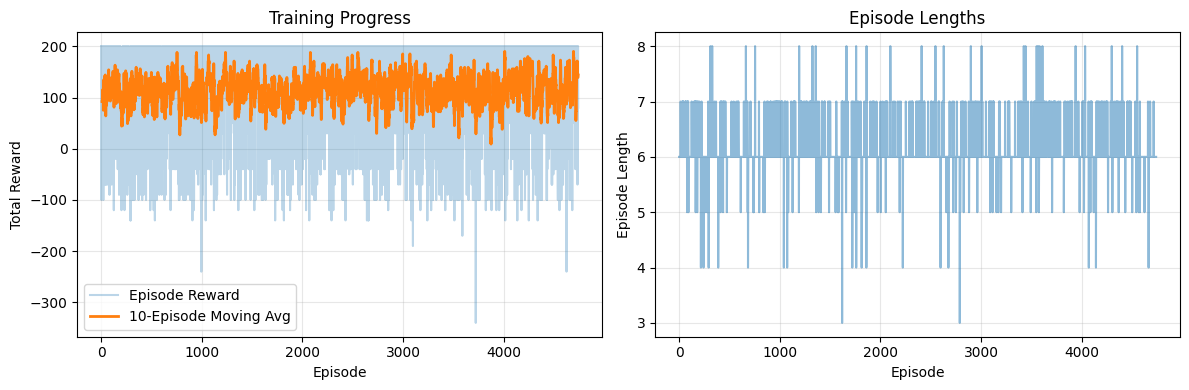

✅ Training plots generated


In [9]:
# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(callback.episode_rewards, alpha=0.3, label='Episode Reward')
# Moving average
window = 10
if len(callback.episode_rewards) >= window:
    moving_avg = np.convolve(callback.episode_rewards, 
                             np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(callback.episode_rewards)), moving_avg, 
             label=f'{window}-Episode Moving Avg', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(callback.episode_lengths, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Lengths')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('✅ Training plots generated')

In [10]:
# Save model and VecNormalize stats with comprehensive metadata
print('💾 Saving optimized model and normalization stats...')

# Save VecNormalize stats
vec_env.save("models/vecnorm_stats.pkl")
eval_env.save("models/eval_vecnorm_stats.pkl")

# Save model with comprehensive metadata
model_path = save_model_with_wandb(
    model, 
    "ppo_atc_optimized",
    metadata={
        "total_timesteps": 200_000,
        "training_time_seconds": training_time,
        "final_success_rate": np.mean(callback.success_rates[-20:]),
        "final_avg_collisions": np.mean(callback.collisions[-20:]),
        "final_avg_reward": np.mean(callback.episode_rewards[-20:]),
        "total_episodes": len(callback.episode_rewards),
        "final_avg_exits": np.mean(callback.successful_exits[-20:]),
        "final_avg_failed_exits": np.mean(callback.failed_exits[-20:]),
        "final_avg_episode_length": np.mean(callback.episode_lengths[-20:]),
        "training_type": "optimized_ppo_with_critic_fixes",
        "optimizations": ["env_wrapping", "separate_nets", "entropy_schedule", "comprehensive_tracking"],
        "environment": "Simple2DATC-Optimized",
        "reward_structure": "normalized_rewards"
    }
)

print('✅ Model and stats saved successfully!')
print(f'   - Model: {model_path}')
print('   - Training VecNormalize stats: models/vecnorm_stats.pkl')
print('   - Evaluation VecNormalize stats: models/eval_vecnorm_stats.pkl')
print('📊 Model artifact logged to wandb!')
print('')
print('🎯 Check exit criteria:')
print('   - explained_variance should be trending 0.3–0.6')
print('   - value_loss should be stable < 1.0')
print('   - approx_kl should be 0.004–0.008')
print('   - clip_fraction should be 0.03–0.08')

💾 Saving optimized model and normalization stats...
✅ Model and stats saved successfully!
   - Model: models/ppo_atc_optimized
   - Training VecNormalize stats: models/vecnorm_stats.pkl
   - Evaluation VecNormalize stats: models/eval_vecnorm_stats.pkl
📊 Model artifact logged to wandb!

🎯 Check exit criteria:
   - explained_variance should be trending 0.3–0.6
   - value_loss should be stable < 1.0
   - approx_kl should be 0.004–0.008
   - clip_fraction should be 0.03–0.08


In [11]:
# Cleanup and finalization
print('🧹 Cleaning up resources...')

# Close environments
vec_env.close()
if 'eval_env' in locals():
    eval_env.close()

# Finish wandb run
wandb.finish()

print('✅ Cleanup complete!')
print('📊 All metrics logged to wandb dashboard')
print('💾 Model saved with full metadata')
print('🎯 Ready for evaluation!')


🧹 Cleaning up resources...


✅ Cleanup complete!
📊 All metrics logged to wandb dashboard
💾 Model saved with full metadata
🎯 Ready for evaluation!


---
# Section 4: Evaluate Trained Agent

Let's watch the trained agent in action!

In [12]:
# Create evaluation environment with improved episode system
eval_env = Simple2DATCEnv(
    max_aircraft=5,
    max_steps=1000,  # Fallback only - episodes end when all aircraft resolved
    render_mode='human',
    progressive_difficulty=True,
    initial_aircraft=2
)

print('Evaluating trained agent with improved episode system...')
print('Watch how it handles aircraft with realistic episode lengths!\n')

obs, info = eval_env.reset()
eval_env.render()

step_count = 0
max_eval_steps = 300  # Limit for demo

while step_count < max_eval_steps:
    # Use trained model to predict action
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    
    if step_count % 30 == 0:
        clear_output(wait=True)
        eval_env.render()
        print(f"Step {step_count}: Aircraft={info['num_aircraft']}, "
              f"Exits={info['successful_exits']}, "
              f"Collisions={info['collided_aircraft']}, "
              f"Failed={info['failed_exits']}, "
              f"Total Spawned={info['total_aircraft_spawned']}, "
              f"Success Rate={info['success_rate']:.1%}, "
              f"Reward={info['total_reward']:.1f}")
        time.sleep(0.3)
    
    if terminated:
        clear_output(wait=True)
        eval_env.render()
        
        print(f"\n🏁 EPISODE COMPLETE! All aircraft resolved!")
        print(f"   Total steps: {step_count}")
        print(f"   Total aircraft spawned: {info['total_aircraft_spawned']}")
        print(f"   Successful exits: {info['successful_exits']}")
        print(f"   Collisions: {info['collided_aircraft']}")
        print(f"   Failed exits: {info['failed_exits']}")
        print(f"   Success rate: {info['success_rate']:.1%}")
        print(f"   Final reward: {info['total_reward']:.1f}")
        
        # Show performance bonus
        if info['success_rate'] >= 0.8:
            print(f"   🏆 Performance bonus: +200 (80%+ success rate)")
        elif info['success_rate'] >= 0.6:
            print(f"   🥈 Performance bonus: +100 (60%+ success rate)")
        elif info['success_rate'] >= 0.4:
            print(f"   🥉 Performance bonus: +50 (40%+ success rate)")
        else:
            print(f"   📉 No performance bonus (<40% success rate)")
        
        break
    
    step_count += 1

print(f"\n✅ Improved Agent Evaluation Complete!")
print(f"\nKey improvements demonstrated:")
print(f"  - Episodes run until all aircraft resolved")
print(f"  - Realistic episode lengths based on actual resolution")
print(f"  - Performance-based rewards encourage overall success")
print(f"  - Better learning opportunity with full consequences")

eval_env.close()


🏁 EPISODE COMPLETE! All aircraft resolved!
   Total steps: 5
   Total aircraft spawned: 2
   Successful exits: 2
   Collisions: 6
   Failed exits: 0
   Success rate: 100.0%
   Final reward: -100.0
   🏆 Performance bonus: +200 (80%+ success rate)

✅ Improved Agent Evaluation Complete!

Key improvements demonstrated:
  - Episodes run until all aircraft resolved
  - Realistic episode lengths based on actual resolution
  - Performance-based rewards encourage overall success
  - Better learning opportunity with full consequences


---
# Section 5: Episode Visualization System

**Record and replay complete simulation episodes with all aircraft movements!**

This section demonstrates the new visualization system that allows you to:
- Record complete episodes during training or evaluation
- Replay episodes with interactive controls (play/pause, speed, timeline scrubbing)
- Visualize aircraft trajectories and conflicts over time
- Save episodes for later analysis


In [ ]:
# Import the visualization system
from atc_rl.visualization import ATCRecorder, ATCPlayer, create_recorder_for_env, visualize_episode
from atc_rl.environment import Simple2DATCEnv

print('✅ Visualization system imported')
print('   - ATCRecorder: Records complete episode state history')
print('   - ATCPlayer: Interactive visualization with controls')
print('   - create_recorder_for_env: Auto-configures recorder for environment')
print('   - visualize_episode: Convenience function for quick visualization')


✅ Visualization system imported
   - ATCRecorder: Records complete episode state history
   - ATCPlayer: Interactive visualization with controls
   - create_recorder_for_env: Auto-configures recorder for environment
   - visualize_episode: Convenience function for quick visualization


In [14]:
# Create environment with recorder
print('🎬 Setting up 2D environment with episode recording...')

# Create recorder for the environment
recorder = create_recorder_for_env(None)  # We'll pass the env after creation

# Create environment with recorder
env = Simple2DATCEnv(
    max_aircraft=5,
    max_steps=100,
    render_mode=None,  # No real-time rendering during recording
    recorder=recorder
)

print('✅ Environment created with recorder')
print(f'   Max aircraft: {env.max_aircraft}')
print(f'   Max steps: {env.max_steps}')
print('   Recorder: Enabled (will record all aircraft states)')


🎬 Setting up 2D environment with episode recording...
✅ Environment created with recorder
   Max aircraft: 5
   Max steps: 100
   Recorder: Enabled (will record all aircraft states)


In [15]:
# Create an extended episode for better visualization
print('🎬 Creating episode for visualization...')

# Create recorder for extended episode
recorder_long = create_recorder_for_env(None)

# Create environment with more complexity for interesting visualization
env_long = Simple2DATCEnv(
    max_aircraft=8,
    max_steps=200,
    render_mode=None,
    recorder=recorder_long,
    progressive_difficulty=False,
    initial_aircraft=5
)

print(f'✅ Environment created: {env_long.max_aircraft} max aircraft, {env_long.max_steps} max steps')
print('')

# Record episode with random policy to create interesting dynamics
print('🎥 Recording episode with random policy...')

obs, info = env_long.reset()
print(f'   Started with {info["num_aircraft"]} aircraft')

step_count = 0
max_steps_to_record = 150

while step_count < max_steps_to_record:
    action = env_long.action_space.sample()
    obs, reward, terminated, truncated, info = env_long.step(action)
    
    step_count += 1
    
    # Print progress every 30 steps
    if step_count % 30 == 0:
        print(f'   Step {step_count}: {info["num_aircraft"]} aircraft, '
              f'Exits: {info["successful_exits"]}, '
              f'Violations: {info["separations_lost"]}')
    
    if terminated or truncated:
        print(f'   Episode ended at step {step_count}')
        break

print(f'✅ Episode recording complete!')
print(f'   Total steps: {step_count}')
print(f'   Aircraft states recorded: {len(recorder_long.aircraft_states)} timesteps')
print(f'   Successful exits: {info["successful_exits"]}')
print(f'   Separation violations: {info["separations_lost"]}')
print('')


🎬 Creating episode for visualization...
✅ Environment created: 8 max aircraft, 200 max steps

🎥 Recording episode with random policy...
   Started with 2 aircraft
   Step 30: 1 aircraft, Exits: 6, Violations: 0
   Episode ended at step 37
✅ Episode recording complete!
   Total steps: 37
   Aircraft states recorded: 37 timesteps
   Successful exits: 8
   Separation violations: 0



In [17]:
# Save episode for later analysis
print('💾 Saving episode data...')

# Save episode data to file
episode_file = 'recorded_2d_episode.pkl'
recorder.save(episode_file)

print(f'✅ Episode saved to {episode_file}')
print('   You can load this episode later using:')
print('   episode_data = ATCRecorder.load("recorded_2d_episode.pkl")')
print('   player = ATCPlayer(episode_data)')
print('   player.show()')


💾 Saving episode data...
Episode saved to recorded_2d_episode.pkl
✅ Episode saved to recorded_2d_episode.pkl
   You can load this episode later using:
   episode_data = ATCRecorder.load("recorded_2d_episode.pkl")
   player = ATCPlayer(episode_data)
   player.show()


## Simple Frame-by-Frame Visualization 

If the animation didn't show, try this simpler approach that displays frames one at a time with a delay.


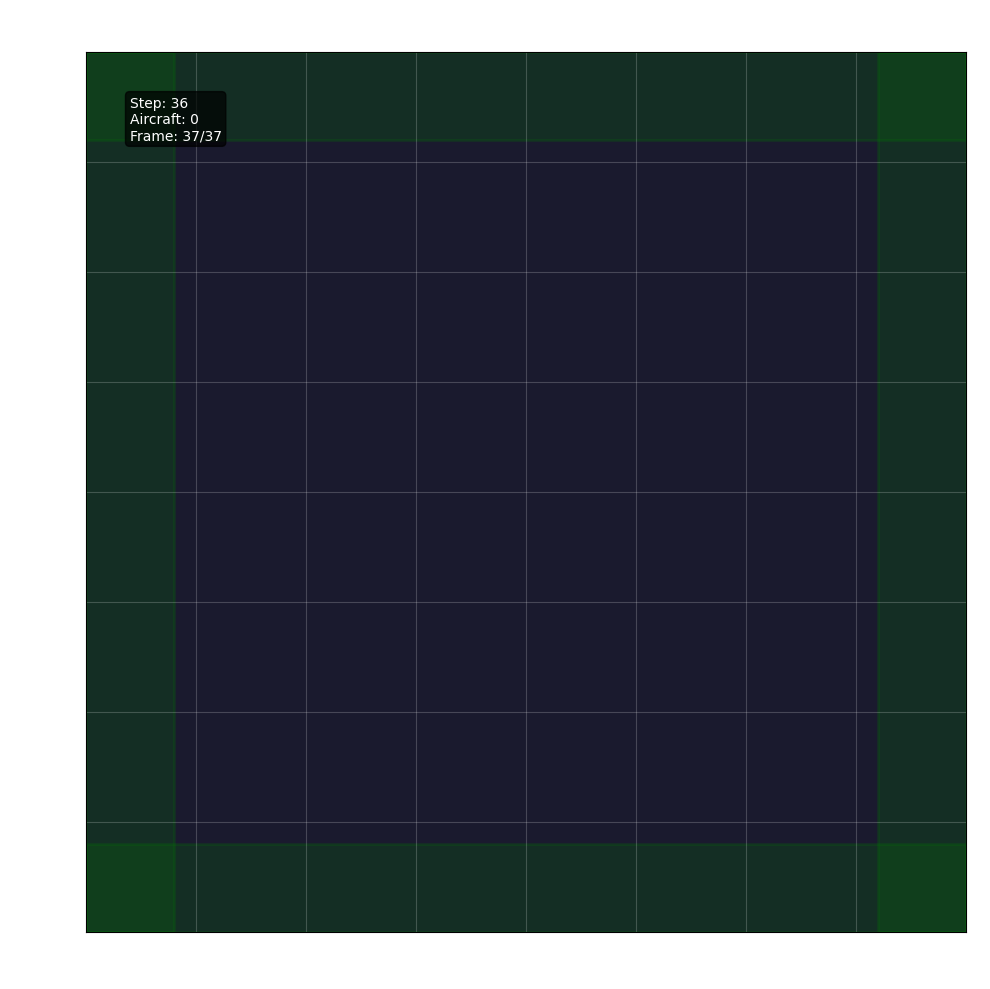

✅ Playback complete!
   Showed 37 frames

💡 To see it again, just re-run this cell!


In [19]:
# Simple frame-by-frame visualization that works in ANY Jupyter setup
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrow, Rectangle
from IPython.display import clear_output
import time

print('🎬 Simple frame-by-frame visualization starting...')
print('   This displays one frame at a time (guaranteed to work!)')
print('')

# Get episode data (use the longer episode if available)
if 'recorder_long' in locals():
    episode_data = recorder_long.get_episode_data()
    print(f'✅ Using longer episode with {len(episode_data["timesteps"])} frames')
else:
    episode_data = recorder.get_episode_data()
    print(f'⚠️  Using original episode with {len(episode_data["timesteps"])} frames')

airspace_size = episode_data['metadata'].get('airspace_size', 20.0)
exit_zone_size = 2.0

# How many frames to show (limit for performance)
num_frames = len(episode_data['timesteps'])
show_every_n = max(1, num_frames // 50)  # Show up to 50 frames max
frame_delay = 0.2  # seconds between frames

print(f'   Showing every {show_every_n} frame(s) with {frame_delay}s delay')
print(f'   Total frames to display: {num_frames // show_every_n}')
print('')
print('🎥 Starting playback...')
print('')

for frame_idx in range(0, num_frames, show_every_n):
    # Clear previous output
    clear_output(wait=True)
    
    # Create figure for this frame
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Setup airspace view
    ax.set_xlim(-airspace_size/2, airspace_size/2)
    ax.set_ylim(-airspace_size/2, airspace_size/2)
    ax.set_aspect('equal')
    ax.set_facecolor('#1a1a2e')
    ax.grid(True, alpha=0.2, color='white')
    ax.set_xlabel('X Position (nm)', color='white', fontsize=12)
    ax.set_ylabel('Y Position (nm)', color='white', fontsize=12)
    ax.tick_params(colors='white')
    
    # Draw exit zones (green rectangles at edges)
    exits = [
        Rectangle((-airspace_size/2, -airspace_size/2), exit_zone_size, airspace_size, 
                  facecolor='green', alpha=0.2, edgecolor='green', linewidth=2),
        Rectangle((airspace_size/2-exit_zone_size, -airspace_size/2), exit_zone_size, airspace_size,
                  facecolor='green', alpha=0.2, edgecolor='green', linewidth=2),
        Rectangle((-airspace_size/2, -airspace_size/2), airspace_size, exit_zone_size,
                  facecolor='green', alpha=0.2, edgecolor='green', linewidth=2),
        Rectangle((-airspace_size/2, airspace_size/2-exit_zone_size), airspace_size, exit_zone_size,
                  facecolor='green', alpha=0.2, edgecolor='green', linewidth=2)
    ]
    for exit_rect in exits:
        ax.add_patch(exit_rect)
    
    # Get frame data
    timestep = episode_data['timesteps'][frame_idx]
    aircraft_states = episode_data['aircraft_states'][frame_idx]
    active_count = len(aircraft_states)
    
    # Draw each aircraft
    for aircraft in aircraft_states:
        x, y = aircraft.x, aircraft.y
        callsign = aircraft.callsign
        
        # Draw trail (last 30 frames)
        trail_start = max(0, frame_idx - 30)
        trail_x, trail_y = [], []
        for t_idx in range(trail_start, frame_idx + 1):
            if t_idx < len(episode_data['aircraft_states']):
                for a in episode_data['aircraft_states'][t_idx]:
                    if a.callsign == callsign:
                        trail_x.append(a.x)
                        trail_y.append(a.y)
                        break
        
        if len(trail_x) > 1:
            ax.plot(trail_x, trail_y, 'cyan', alpha=0.3, linewidth=1)
        
        # Draw aircraft as circle
        circle = Circle((x, y), 0.5, facecolor='yellow', edgecolor='white', linewidth=2, zorder=5)
        ax.add_patch(circle)
        
        # Draw heading indicator
        heading = aircraft.heading
        dx = 0.8 * np.cos(np.radians(heading))
        dy = 0.8 * np.sin(np.radians(heading))
        arrow = FancyArrow(x, y, dx, dy, width=0.2, head_width=0.4, head_length=0.3,
                          facecolor='white', edgecolor='white', zorder=6)
        ax.add_patch(arrow)
        
        # Draw callsign
        ax.text(x, y + 0.8, callsign, color='white', fontsize=8,
                ha='center', va='bottom', zorder=7)
    
    # Add info text
    ax.text(-airspace_size/2 + 1, airspace_size/2 - 1,
            f"Step: {timestep}\nAircraft: {active_count}\nFrame: {frame_idx + 1}/{num_frames}",
            color='white', fontsize=10, va='top',
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    ax.set_title(f'ATC Episode - Frame {frame_idx + 1}/{num_frames}', 
                 color='white', fontsize=14, pad=20)
    
    # Display the frame
    plt.tight_layout()
    plt.show()
    
    # Wait before next frame
    time.sleep(frame_delay)
    
    # Close figure to free memory
    plt.close(fig)

print('✅ Playback complete!')
print(f'   Showed {num_frames // show_every_n} frames')
print('')
print('💡 To see it again, just re-run this cell!')
